# Stock value prediction from Open, High, Low

# Import module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt2
import pandas as pd
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import pandas_datareader.data as web
import h5py

Using TensorFlow backend.


# Input parameters 

In [2]:
stock_name = '^GSPC'
seq_len = 22
d = 0.2
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

# 1. Download data and normalize it
Data since 1950 to today

In [3]:
def get_stock_data(stock_name, normalize=True):
    start = datetime.datetime(1950, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    df.drop(['Volume', 'Close'], 1, inplace=True)
    
    if normalize:        
        min_max_scaler = preprocessing.MinMaxScaler()
        df['Open'] = min_max_scaler.fit_transform(df.Open.values.reshape(-1,1))
        df['High'] = min_max_scaler.fit_transform(df.High.values.reshape(-1,1))
        df['Low'] = min_max_scaler.fit_transform(df.Low.values.reshape(-1,1))
        df['Adj Close'] = min_max_scaler.fit_transform(df['Adj Close'].values.reshape(-1,1))
    return df

In [6]:
df = get_stock_data(stock_name, normalize=True)

# 2. Plot out the Normalized Adjusted close price

In [4]:
def plot_stock(stock_name):
    df = get_stock_data(stock_name, normalize=True)
    print(df.head())
    plt.plot(df['Adj Close'], color='red', label='Adj Close')
    plt.legend(loc='best')
    plt.show()

                Open      High       Low  Adj Close
Date                                               
1950-01-03  0.000000  0.000000  0.000000   0.000000
1950-01-04  0.000080  0.000080  0.000080   0.000080
1950-01-05  0.000114  0.000113  0.000114   0.000113
1950-01-06  0.000135  0.000134  0.000135   0.000134
1950-01-09  0.000177  0.000176  0.000177   0.000176


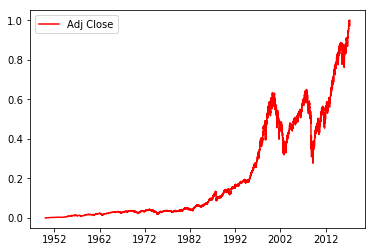

In [8]:
plot_stock(stock_name)

# 3. Set last day Adjusted Close as y

In [5]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns)
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    
    train = result[:int(row), :] # 90% date
    X_train = train[:, :-1] # all data until day m
    y_train = train[:, -1][:,-1] # day m + 1 adjusted close price
    
    X_test = result[int(row):, :-1]
    y_test = result[int(row):, -1][:,-1] 

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], amount_of_features))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], amount_of_features))  

    return [X_train, y_train, X_test, y_test]

In [24]:
X_train, y_train, X_test, y_test = load_data(df, seq_len)

In [25]:
X_train.shape[0], X_train.shape[1], X_train.shape[2]

(15230, 22, 4)

In [26]:
y_train.shape[0]

15230

# 4. Buidling neural network

In [6]:
def build_model2(layers, neurons, d):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    # adam = keras.optimizers.Adam(decay=0.2)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

# 6. Model Execution

In [28]:
model = build_model2(shape, neurons, d)
# layers = [4, 22, 1]

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 128)           68096     
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 128)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128)               131584    
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.fit(
    X_train,
    y_train,
    batch_size=512,
    epochs=epochs,
    validation_split=0.1,
    verbose=1)

Train on 13702 samples, validate on 1523 samples
Epoch 1/300
13702/13702 [==============================] - 3s - loss: 0.0136 - acc: 0.0000e+00 - val_loss: 0.0039 - val_acc: 0.0000e+00
Epoch 2/300
13702/13702 [==============================] - 1s - loss: 6.4231e-04 - acc: 0.0000e+00 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 3/300
13702/13702 [==============================] - 1s - loss: 2.1697e-04 - acc: 0.0000e+00 - val_loss: 5.5174e-04 - val_acc: 0.0000e+00
Epoch 4/300
13702/13702 [==============================] - 1s - loss: 1.5014e-04 - acc: 0.0000e+00 - val_loss: 3.5958e-04 - val_acc: 0.0000e+00
Epoch 5/300
13702/13702 [==============================] - 1s - loss: 1.4812e-04 - acc: 0.0000e+00 - val_loss: 2.5470e-04 - val_acc: 0.0000e+00
Epoch 6/300
13702/13702 [==============================] - 1s - loss: 1.4567e-04 - acc: 0.0000e+00 - val_loss: 4.2694e-04 - val_acc: 0.0000e+00
Epoch 7/300
13702/13702 [==============================] - 1s - loss: 1.3548e-04 - acc: 0.0000e+00 

13702/13702 [==============================] - 1s - loss: 6.5203e-05 - acc: 0.0000e+00 - val_loss: 1.0664e-04 - val_acc: 0.0000e+00
Epoch 114/300
13702/13702 [==============================] - 1s - loss: 6.1330e-05 - acc: 0.0000e+00 - val_loss: 1.7641e-04 - val_acc: 0.0000e+00
Epoch 115/300
13702/13702 [==============================] - 1s - loss: 6.6250e-05 - acc: 0.0000e+00 - val_loss: 9.6615e-05 - val_acc: 0.0000e+00
Epoch 116/300
13702/13702 [==============================] - 1s - loss: 5.8570e-05 - acc: 0.0000e+00 - val_loss: 9.5838e-05 - val_acc: 0.0000e+00
Epoch 117/300
13702/13702 [==============================] - 1s - loss: 5.9823e-05 - acc: 0.0000e+00 - val_loss: 2.5840e-04 - val_acc: 0.0000e+00
Epoch 118/300
13702/13702 [==============================] - 1s - loss: 7.8547e-05 - acc: 0.0000e+00 - val_loss: 2.4948e-04 - val_acc: 0.0000e+00
Epoch 119/300
13702/13702 [==============================] - 1s - loss: 6.2506e-05 - acc: 0.0000e+00 - val_loss: 1.0067e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.8500e-05 - acc: 0.0000e+00 - val_loss: 9.2846e-05 - val_acc: 0.0000e+00
Epoch 226/300
13702/13702 [==============================] - 1s - loss: 3.7036e-05 - acc: 0.0000e+00 - val_loss: 1.2782e-04 - val_acc: 0.0000e+00
Epoch 227/300
13702/13702 [==============================] - 1s - loss: 4.2135e-05 - acc: 0.0000e+00 - val_loss: 6.7895e-05 - val_acc: 0.0000e+00
Epoch 228/300
13702/13702 [==============================] - 1s - loss: 3.4487e-05 - acc: 0.0000e+00 - val_loss: 8.3031e-05 - val_acc: 0.0000e+00
Epoch 229/300
13702/13702 [==============================] - 1s - loss: 3.3446e-05 - acc: 0.0000e+00 - val_loss: 6.5587e-05 - val_acc: 0.0000e+00
Epoch 230/300
13702/13702 [==============================] - 1s - loss: 3.3349e-05 - acc: 0.0000e+00 - val_loss: 8.3603e-05 - val_acc: 0.0000e+00
Epoch 231/300
13702/13702 [==============================] - 1s - loss: 3.3717e-05 - acc: 0.0000e+00 - val_loss: 8.8869e-05 - val_acc: 0.0

# 7. Result on training set and testing set

In [7]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

In [18]:
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00006 MSE (0.01 RMSE)
Test Score: 0.00029 MSE (0.02 RMSE)


(5.7438499461150269e-05, 0.00028581792180730253)

# 8. Prediction vs Real results

In [8]:
def percentage_difference(model, X_test, y_test):
    percentage_diff=[]

    p = model.predict(X_test)
    for u in range(len(y_test)): # for each data index in test data
        pr = p[u][0] # pr = prediction on day u

        percentage_diff.append((pr-y_test[u]/pr)*100)
    return p

In [20]:
p = percentage_difference(model, X_test, y_test)

# 9. Plot out prediction

In [9]:
def denormalize(stock_name, normalized_value):
    start = datetime.datetime(2000, 1, 1)
    end = datetime.date.today()
    df = web.DataReader(stock_name, "yahoo", start, end)
    
    df = df['Adj Close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

In [10]:
def plot_result(stock_name, normalized_value_p, normalized_value_y_test):
    newp = denormalize(stock_name, normalized_value_p)
    newy_test = denormalize(stock_name, normalized_value_y_test)
    plt2.plot(newp, color='red', label='Prediction')
    plt2.plot(newy_test,color='blue', label='Actual')
    plt2.legend(loc='best')
    plt2.title('The test result for {}'.format(stock_name))
    plt2.xlabel('Days')
    plt2.ylabel('Adjusted Close')
    plt2.show()

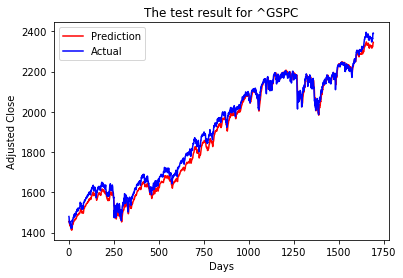

In [23]:
plot_result(stock_name, p, y_test)

# 10. Save for consistency

In [24]:
# model.save('LSTM_Stock_prediction-20170429.h5')

# Part 2. Fine tune model
# 11. Function to load data, train model and see score

In [11]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochs = 300

In [11]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model2(shape, neurons, d)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

# 12. Fine tune hyperparameter

12.1 Optimial Dropout value

In [23]:
dlist = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
neurons_LSTM = [32, 64, 128, 256, 512, 1024, 2048]
dropout_result = {}

for d in dlist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    dropout_result[d] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_17 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_18 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_17 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_18 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

13702/13702 [==============================] - 1s - loss: 6.1786e-05 - acc: 0.0000e+00 - val_loss: 2.3667e-04 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 6.4980e-05 - acc: 0.0000e+00 - val_loss: 1.2261e-04 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 6.8195e-05 - acc: 0.0000e+00 - val_loss: 1.3106e-04 - val_acc: 0.0000e+00
Epoch 108/300
13702/13702 [==============================] - 1s - loss: 6.2237e-05 - acc: 0.0000e+00 - val_loss: 1.2377e-04 - val_acc: 0.0000e+00
Epoch 109/300
13702/13702 [==============================] - 1s - loss: 6.1468e-05 - acc: 0.0000e+00 - val_loss: 1.0991e-04 - val_acc: 0.0000e+00
Epoch 110/300
13702/13702 [==============================] - 1s - loss: 6.7530e-05 - acc: 0.0000e+00 - val_loss: 1.1433e-04 - val_acc: 0.0000e+00
Epoch 111/300
13702/13702 [==============================] - 1s - loss: 6.1319e-05 - acc: 0.0000e+00 - val_loss: 9.6058e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.9481e-05 - acc: 0.0000e+00 - val_loss: 8.4440e-05 - val_acc: 0.0000e+00
Epoch 218/300
13702/13702 [==============================] - 1s - loss: 3.7271e-05 - acc: 0.0000e+00 - val_loss: 7.6987e-05 - val_acc: 0.0000e+00
Epoch 219/300
13702/13702 [==============================] - 1s - loss: 3.8756e-05 - acc: 0.0000e+00 - val_loss: 7.4955e-05 - val_acc: 0.0000e+00
Epoch 220/300
13702/13702 [==============================] - 1s - loss: 3.6757e-05 - acc: 0.0000e+00 - val_loss: 7.2061e-05 - val_acc: 0.0000e+00
Epoch 221/300
13702/13702 [==============================] - 1s - loss: 3.7897e-05 - acc: 0.0000e+00 - val_loss: 8.6368e-05 - val_acc: 0.0000e+00
Epoch 222/300
13702/13702 [==============================] - 1s - loss: 4.0011e-05 - acc: 0.0000e+00 - val_loss: 6.7412e-05 - val_acc: 0.0000e+00
Epoch 223/300
13702/13702 [==============================] - 1s - loss: 3.6490e-05 - acc: 0.0000e+00 - val_loss: 1.0807e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 1.5562e-04 - acc: 0.0000e+00 - val_loss: 6.4125e-04 - val_acc: 0.0000e+00
Epoch 21/300
13702/13702 [==============================] - 1s - loss: 1.6698e-04 - acc: 0.0000e+00 - val_loss: 3.1872e-04 - val_acc: 0.0000e+00
Epoch 22/300
13702/13702 [==============================] - 1s - loss: 1.7413e-04 - acc: 0.0000e+00 - val_loss: 3.2942e-04 - val_acc: 0.0000e+00
Epoch 23/300
13702/13702 [==============================] - 1s - loss: 1.4956e-04 - acc: 0.0000e+00 - val_loss: 2.0891e-04 - val_acc: 0.0000e+00
Epoch 24/300
13702/13702 [==============================] - 1s - loss: 1.5216e-04 - acc: 0.0000e+00 - val_loss: 5.3458e-04 - val_acc: 0.0000e+00
Epoch 25/300
13702/13702 [==============================] - 1s - loss: 1.4924e-04 - acc: 0.0000e+00 - val_loss: 1.9061e-04 - val_acc: 0.0000e+00
Epoch 26/300
13702/13702 [==============================] - 1s - loss: 1.5519e-04 - acc: 0.0000e+00 - val_loss: 3.3778e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 6.3433e-05 - acc: 0.0000e+00 - val_loss: 2.7105e-04 - val_acc: 0.0000e+00
Epoch 133/300
13702/13702 [==============================] - 1s - loss: 7.4739e-05 - acc: 0.0000e+00 - val_loss: 2.7288e-04 - val_acc: 0.0000e+00
Epoch 134/300
13702/13702 [==============================] - 1s - loss: 6.7838e-05 - acc: 0.0000e+00 - val_loss: 1.0321e-04 - val_acc: 0.0000e+00
Epoch 135/300
13702/13702 [==============================] - 1s - loss: 6.9862e-05 - acc: 0.0000e+00 - val_loss: 1.3938e-04 - val_acc: 0.0000e+00
Epoch 136/300
13702/13702 [==============================] - 1s - loss: 7.9317e-05 - acc: 0.0000e+00 - val_loss: 1.3731e-04 - val_acc: 0.0000e+00
Epoch 137/300
13702/13702 [==============================] - 1s - loss: 7.0154e-05 - acc: 0.0000e+00 - val_loss: 1.9247e-04 - val_acc: 0.0000e+00
Epoch 138/300
13702/13702 [==============================] - 1s - loss: 6.4486e-05 - acc: 0.0000e+00 - val_loss: 1.5125e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 3.9698e-05 - acc: 0.0000e+00 - val_loss: 8.6679e-04 - val_acc: 0.0000e+00
Epoch 244/300
13702/13702 [==============================] - 1s - loss: 4.0289e-05 - acc: 0.0000e+00 - val_loss: 6.7704e-04 - val_acc: 0.0000e+00
Epoch 245/300
13702/13702 [==============================] - 1s - loss: 4.5648e-05 - acc: 0.0000e+00 - val_loss: 5.4294e-04 - val_acc: 0.0000e+00
Epoch 246/300
13702/13702 [==============================] - 1s - loss: 4.4502e-05 - acc: 0.0000e+00 - val_loss: 3.3888e-04 - val_acc: 0.0000e+00
Epoch 247/300
13702/13702 [==============================] - 1s - loss: 4.0186e-05 - acc: 0.0000e+00 - val_loss: 3.5092e-04 - val_acc: 0.0000e+00
Epoch 248/300
13702/13702 [==============================] - 1s - loss: 4.7147e-05 - acc: 0.0000e+00 - val_loss: 4.3610e-04 - val_acc: 0.0000e+00
Epoch 249/300
13702/13702 [==============================] - 1s - loss: 3.8760e-05 - acc: 0.0000e+00 - val_loss: 6.7867e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 1.8026e-04 - acc: 0.0000e+00 - val_loss: 2.4794e-04 - val_acc: 0.0000e+00
Epoch 48/300
13702/13702 [==============================] - 1s - loss: 1.7000e-04 - acc: 0.0000e+00 - val_loss: 3.5737e-04 - val_acc: 0.0000e+00
Epoch 49/300
13702/13702 [==============================] - 1s - loss: 1.6763e-04 - acc: 0.0000e+00 - val_loss: 1.6839e-04 - val_acc: 0.0000e+00
Epoch 50/300
13702/13702 [==============================] - 1s - loss: 1.5622e-04 - acc: 0.0000e+00 - val_loss: 1.7348e-04 - val_acc: 0.0000e+00
Epoch 51/300
13702/13702 [==============================] - 1s - loss: 1.5985e-04 - acc: 0.0000e+00 - val_loss: 1.6267e-04 - val_acc: 0.0000e+00
Epoch 52/300
13702/13702 [==============================] - 1s - loss: 1.6144e-04 - acc: 0.0000e+00 - val_loss: 3.1402e-04 - val_acc: 0.0000e+00
Epoch 53/300
13702/13702 [==============================] - 1s - loss: 1.7031e-04 - acc: 0.0000e+00 - val_loss: 8.4756e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 7.1296e-05 - acc: 0.0000e+00 - val_loss: 1.4057e-04 - val_acc: 0.0000e+00
Epoch 160/300
13702/13702 [==============================] - 1s - loss: 6.1691e-05 - acc: 0.0000e+00 - val_loss: 1.1298e-04 - val_acc: 0.0000e+00
Epoch 161/300
13702/13702 [==============================] - 1s - loss: 6.9301e-05 - acc: 0.0000e+00 - val_loss: 1.1585e-04 - val_acc: 0.0000e+00
Epoch 162/300
13702/13702 [==============================] - 1s - loss: 6.4087e-05 - acc: 0.0000e+00 - val_loss: 1.5222e-04 - val_acc: 0.0000e+00
Epoch 163/300
13702/13702 [==============================] - 1s - loss: 6.3793e-05 - acc: 0.0000e+00 - val_loss: 1.7010e-04 - val_acc: 0.0000e+00
Epoch 164/300
13702/13702 [==============================] - 1s - loss: 6.8608e-05 - acc: 0.0000e+00 - val_loss: 3.1628e-04 - val_acc: 0.0000e+00
Epoch 165/300
13702/13702 [==============================] - 1s - loss: 7.0132e-05 - acc: 0.0000e+00 - val_loss: 1.1609e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 4.9399e-05 - acc: 0.0000e+00 - val_loss: 1.0380e-04 - val_acc: 0.0000e+00
Epoch 272/300
13702/13702 [==============================] - 1s - loss: 5.3103e-05 - acc: 0.0000e+00 - val_loss: 1.4977e-04 - val_acc: 0.0000e+00
Epoch 273/300
13702/13702 [==============================] - 1s - loss: 5.3189e-05 - acc: 0.0000e+00 - val_loss: 1.3721e-04 - val_acc: 0.0000e+00
Epoch 274/300
13702/13702 [==============================] - 1s - loss: 5.2630e-05 - acc: 0.0000e+00 - val_loss: 1.1542e-04 - val_acc: 0.0000e+00
Epoch 275/300
13702/13702 [==============================] - 1s - loss: 4.9756e-05 - acc: 0.0000e+00 - val_loss: 9.4683e-05 - val_acc: 0.0000e+00
Epoch 276/300
13702/13702 [==============================] - 1s - loss: 4.7233e-05 - acc: 0.0000e+00 - val_loss: 9.0343e-05 - val_acc: 0.0000e+00
Epoch 277/300
13702/13702 [==============================] - 1s - loss: 4.5547e-05 - acc: 0.0000e+00 - val_loss: 9.0549e-05 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 1.2303e-04 - acc: 0.0000e+00 - val_loss: 1.8200e-04 - val_acc: 0.0000e+00
Epoch 75/300
13702/13702 [==============================] - 1s - loss: 1.1591e-04 - acc: 0.0000e+00 - val_loss: 1.8617e-04 - val_acc: 0.0000e+00
Epoch 76/300
13702/13702 [==============================] - 1s - loss: 1.2509e-04 - acc: 0.0000e+00 - val_loss: 1.7907e-04 - val_acc: 0.0000e+00
Epoch 77/300
13702/13702 [==============================] - 1s - loss: 1.1656e-04 - acc: 0.0000e+00 - val_loss: 4.6717e-04 - val_acc: 0.0000e+00
Epoch 78/300
13702/13702 [==============================] - 1s - loss: 1.1367e-04 - acc: 0.0000e+00 - val_loss: 1.9309e-04 - val_acc: 0.0000e+00
Epoch 79/300
13702/13702 [==============================] - 1s - loss: 1.1463e-04 - acc: 0.0000e+00 - val_loss: 3.0223e-04 - val_acc: 0.0000e+00
Epoch 80/300
13702/13702 [==============================] - 1s - loss: 1.4130e-04 - acc: 0.0000e+00 - val_loss: 4.0616e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 7.0011e-05 - acc: 0.0000e+00 - val_loss: 1.3751e-04 - val_acc: 0.0000e+00
Epoch 186/300
13702/13702 [==============================] - 1s - loss: 7.2437e-05 - acc: 0.0000e+00 - val_loss: 1.4915e-04 - val_acc: 0.0000e+00
Epoch 187/300
13702/13702 [==============================] - 1s - loss: 7.0253e-05 - acc: 0.0000e+00 - val_loss: 1.3225e-04 - val_acc: 0.0000e+00
Epoch 188/300
13702/13702 [==============================] - 1s - loss: 7.2093e-05 - acc: 0.0000e+00 - val_loss: 1.9258e-04 - val_acc: 0.0000e+00
Epoch 189/300
13702/13702 [==============================] - 1s - loss: 7.4188e-05 - acc: 0.0000e+00 - val_loss: 1.4524e-04 - val_acc: 0.0000e+00
Epoch 190/300
13702/13702 [==============================] - 1s - loss: 7.2855e-05 - acc: 0.0000e+00 - val_loss: 2.9472e-04 - val_acc: 0.0000e+00
Epoch 191/300
13702/13702 [==============================] - 1s - loss: 7.2461e-05 - acc: 0.0000e+00 - val_loss: 1.4657e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 5.6324e-05 - acc: 0.0000e+00 - val_loss: 2.8671e-04 - val_acc: 0.0000e+00
Epoch 298/300
13702/13702 [==============================] - 1s - loss: 5.9531e-05 - acc: 0.0000e+00 - val_loss: 2.0190e-04 - val_acc: 0.0000e+00
Epoch 299/300
13702/13702 [==============================] - 1s - loss: 6.8640e-05 - acc: 0.0000e+00 - val_loss: 3.7049e-04 - val_acc: 0.0000e+00
Epoch 300/300
13702/13702 [==============================] - 1s - loss: 6.4655e-05 - acc: 0.0000e+00 - val_loss: 1.9034e-04 - val_acc: 0.0000e+00
Train Score: 0.00004 MSE (0.01 RMSE)
Test Score: 0.01902 MSE (0.14 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_25 (Dropout)         (None, 22, 128)           0         
___________________________

13702/13702 [==============================] - 1s - loss: 1.0123e-04 - acc: 0.0000e+00 - val_loss: 4.0034e-04 - val_acc: 0.0000e+00
Epoch 102/300
13702/13702 [==============================] - 1s - loss: 1.0113e-04 - acc: 0.0000e+00 - val_loss: 2.7637e-04 - val_acc: 0.0000e+00
Epoch 103/300
13702/13702 [==============================] - 1s - loss: 1.0429e-04 - acc: 0.0000e+00 - val_loss: 1.7193e-04 - val_acc: 0.0000e+00
Epoch 104/300
13702/13702 [==============================] - 1s - loss: 1.1349e-04 - acc: 0.0000e+00 - val_loss: 2.3464e-04 - val_acc: 0.0000e+00
Epoch 105/300
13702/13702 [==============================] - 1s - loss: 1.1262e-04 - acc: 0.0000e+00 - val_loss: 1.6379e-04 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 1.1030e-04 - acc: 0.0000e+00 - val_loss: 1.4948e-04 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 1.0890e-04 - acc: 0.0000e+00 - val_loss: 1.7867e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 9.7080e-05 - acc: 0.0000e+00 - val_loss: 1.6134e-04 - val_acc: 0.0000e+00
Epoch 158/300
13702/13702 [==============================] - 1s - loss: 9.8794e-05 - acc: 0.0000e+00 - val_loss: 1.9032e-04 - val_acc: 0.0000e+00
Epoch 159/300
13702/13702 [==============================] - 1s - loss: 8.6255e-05 - acc: 0.0000e+00 - val_loss: 1.8715e-04 - val_acc: 0.0000e+00
Epoch 160/300
13702/13702 [==============================] - 1s - loss: 8.5782e-05 - acc: 0.0000e+00 - val_loss: 1.8604e-04 - val_acc: 0.0000e+00
Epoch 161/300
13702/13702 [==============================] - 1s - loss: 9.1113e-05 - acc: 0.0000e+00 - val_loss: 2.5892e-04 - val_acc: 0.0000e+00
Epoch 162/300
13702/13702 [==============================] - 1s - loss: 8.7331e-05 - acc: 0.0000e+00 - val_loss: 2.1153e-04 - val_acc: 0.0000e+00
Epoch 163/300
13702/13702 [==============================] - 1s - loss: 8.6033e-05 - acc: 0.0000e+00 - val_loss: 2.3757e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 7.5105e-05 - acc: 0.0000e+00 - val_loss: 1.8325e-04 - val_acc: 0.0000e+00
Epoch 269/300
13702/13702 [==============================] - 1s - loss: 7.1055e-05 - acc: 0.0000e+00 - val_loss: 2.6456e-04 - val_acc: 0.0000e+00
Epoch 270/300
13702/13702 [==============================] - 1s - loss: 6.7923e-05 - acc: 0.0000e+00 - val_loss: 2.3129e-04 - val_acc: 0.0000e+00
Epoch 271/300
13702/13702 [==============================] - 1s - loss: 6.9181e-05 - acc: 0.0000e+00 - val_loss: 2.7518e-04 - val_acc: 0.0000e+00
Epoch 272/300
13702/13702 [==============================] - 1s - loss: 7.3365e-05 - acc: 0.0000e+00 - val_loss: 3.3132e-04 - val_acc: 0.0000e+00
Epoch 273/300
13702/13702 [==============================] - 1s - loss: 6.9777e-05 - acc: 0.0000e+00 - val_loss: 1.6098e-04 - val_acc: 0.0000e+00
Epoch 274/300
13702/13702 [==============================] - 1s - loss: 7.0377e-05 - acc: 0.0000e+00 - val_loss: 2.4420e-04 - val_acc: 0.0

13702/13702 [==============================] - 1s - loss: 1.6657e-04 - acc: 0.0000e+00 - val_loss: 3.1592e-04 - val_acc: 0.0000e+00
Epoch 73/300
13702/13702 [==============================] - 1s - loss: 1.6380e-04 - acc: 0.0000e+00 - val_loss: 2.7866e-04 - val_acc: 0.0000e+00
Epoch 74/300
13702/13702 [==============================] - 1s - loss: 1.5932e-04 - acc: 0.0000e+00 - val_loss: 3.1835e-04 - val_acc: 0.0000e+00
Epoch 75/300
13702/13702 [==============================] - 1s - loss: 1.5005e-04 - acc: 0.0000e+00 - val_loss: 4.3268e-04 - val_acc: 0.0000e+00
Epoch 76/300
13702/13702 [==============================] - 1s - loss: 1.4746e-04 - acc: 0.0000e+00 - val_loss: 7.5370e-04 - val_acc: 0.0000e+00
Epoch 77/300
13702/13702 [==============================] - 1s - loss: 1.5394e-04 - acc: 0.0000e+00 - val_loss: 3.2292e-04 - val_acc: 0.0000e+00
Epoch 78/300
13702/13702 [==============================] - 1s - loss: 1.5239e-04 - acc: 0.0000e+00 - val_loss: 5.2693e-04 - val_acc: 0.0000e+0

13702/13702 [==============================] - 1s - loss: 1.0890e-04 - acc: 0.0000e+00 - val_loss: 0.0030 - val_acc: 0.0000e+00
Epoch 185/300
13702/13702 [==============================] - 1s - loss: 1.0187e-04 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 186/300
13702/13702 [==============================] - 1s - loss: 1.1207e-04 - acc: 0.0000e+00 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 187/300
13702/13702 [==============================] - 1s - loss: 1.1059e-04 - acc: 0.0000e+00 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 188/300
13702/13702 [==============================] - 1s - loss: 1.0803e-04 - acc: 0.0000e+00 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 189/300
13702/13702 [==============================] - 1s - loss: 1.0134e-04 - acc: 0.0000e+00 - val_loss: 0.0018 - val_acc: 0.0000e+000.000
Epoch 190/300
13702/13702 [==============================] - 1s - loss: 1.0001e-04 - acc: 0.0000e+00 - val_loss: 0.0026 - val_acc: 0.0000e+00
Epoch 191/300
1

13702/13702 [==============================] - 1s - loss: 7.9138e-05 - acc: 0.0000e+00 - val_loss: 0.0060 - val_acc: 0.0000e+00
Epoch 299/300
13702/13702 [==============================] - 1s - loss: 7.6621e-05 - acc: 0.0000e+00 - val_loss: 0.0066 - val_acc: 0.0000e+00
Epoch 300/300
13702/13702 [==============================] - 1s - loss: 7.7939e-05 - acc: 0.0000e+00 - val_loss: 0.0065 - val_acc: 0.0000e+00
Train Score: 0.00119 MSE (0.03 RMSE)
Test Score: 0.06796 MSE (0.26 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_29 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_29 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_30 (LSTM)               (None, 128)               131584    
_____________________________________________________

13702/13702 [==============================] - 1s - loss: 1.5937e-04 - acc: 0.0000e+00 - val_loss: 0.0191 - val_acc: 0.0000e+00
Epoch 106/300
13702/13702 [==============================] - 1s - loss: 1.6408e-04 - acc: 0.0000e+00 - val_loss: 0.0204 - val_acc: 0.0000e+00
Epoch 107/300
13702/13702 [==============================] - 1s - loss: 1.7346e-04 - acc: 0.0000e+00 - val_loss: 0.0188 - val_acc: 0.0000e+00
Epoch 108/300
13702/13702 [==============================] - 1s - loss: 1.7607e-04 - acc: 0.0000e+00 - val_loss: 0.0209 - val_acc: 0.0000e+00
Epoch 109/300
13702/13702 [==============================] - 1s - loss: 1.6748e-04 - acc: 0.0000e+00 - val_loss: 0.0222 - val_acc: 0.0000e+00
Epoch 110/300
13702/13702 [==============================] - 1s - loss: 1.6552e-04 - acc: 0.0000e+00 - val_loss: 0.0213 - val_acc: 0.0000e+00
Epoch 111/300
13702/13702 [==============================] - 1s - loss: 1.6837e-04 - acc: 0.0000e+00 - val_loss: 0.0215 - val_acc: 0.0000e+00
Epoch 112/300
13702/

13702/13702 [==============================] - 1s - loss: 1.2767e-04 - acc: 0.0000e+00 - val_loss: 0.0346 - val_acc: 0.0000e+00
Epoch 220/300
13702/13702 [==============================] - 1s - loss: 1.3333e-04 - acc: 0.0000e+00 - val_loss: 0.0350 - val_acc: 0.0000e+00
Epoch 221/300
13702/13702 [==============================] - 1s - loss: 1.2127e-04 - acc: 0.0000e+00 - val_loss: 0.0360 - val_acc: 0.0000e+00
Epoch 222/300
13702/13702 [==============================] - 1s - loss: 1.3149e-04 - acc: 0.0000e+00 - val_loss: 0.0349 - val_acc: 0.0000e+00
Epoch 223/300
13702/13702 [==============================] - 1s - loss: 1.3118e-04 - acc: 0.0000e+00 - val_loss: 0.0347 - val_acc: 0.0000e+00
Epoch 224/300
13702/13702 [==============================] - 1s - loss: 1.3272e-04 - acc: 0.0000e+00 - val_loss: 0.0339 - val_acc: 0.0000e+00
Epoch 225/300
13702/13702 [==============================] - 1s - loss: 1.2200e-04 - acc: 0.0000e+00 - val_loss: 0.0352 - val_acc: 0.0000e+00
Epoch 226/300
13702/

In [24]:
min_val = min(dropout_result.values())
min_val_key = [k for k, v in dropout_result.items() if v == min_val]
print (dropout_result)
print (min_val_key)

{0.2: 9.0012162654516434e-05, 0.3: 0.0022254438251234927, 0.8: 0.15819754752706974, 0.5: 0.01902325010867283, 0.7: 0.067955376763099332, 0.4: 0.01020233225110141, 0.6: 0.038046965636445065}
[0.2]


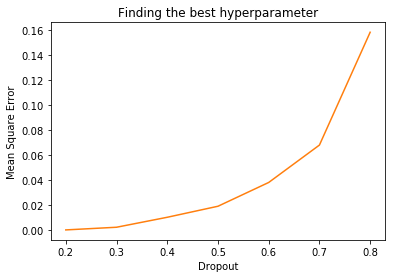

In [34]:
lists = sorted(dropout_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Dropout')
plt.ylabel('Mean Square Error')
plt.show()

12.2 Optimial epochs value

In [29]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [128, 128, 32, 1]
epochslist = [10,20,30,40,50,60,70,80,90,100]

In [30]:
epochs_result = {}

for epochs in epochslist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
    epochs_result[epochs] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_11 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_11 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_12 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 32)                4128      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 33        
Total params: 203,841
Trainable params: 203,841
Non-trainable params: 0
_________________________________________________________________
Trai

13702/13702 [==============================] - 1s - loss: 1.1510e-04 - acc: 0.0000e+00 - val_loss: 2.0423e-04 - val_acc: 0.0000e+00
Epoch 21/40
13702/13702 [==============================] - 1s - loss: 1.3198e-04 - acc: 0.0000e+00 - val_loss: 3.1054e-04 - val_acc: 0.0000e+00
Epoch 22/40
13702/13702 [==============================] - 1s - loss: 1.1354e-04 - acc: 0.0000e+00 - val_loss: 3.9297e-04 - val_acc: 0.0000e+00
Epoch 23/40
13702/13702 [==============================] - 1s - loss: 1.1534e-04 - acc: 0.0000e+00 - val_loss: 2.6460e-04 - val_acc: 0.0000e+00
Epoch 24/40
13702/13702 [==============================] - 1s - loss: 1.0624e-04 - acc: 0.0000e+00 - val_loss: 2.4153e-04 - val_acc: 0.0000e+00
Epoch 25/40
13702/13702 [==============================] - 1s - loss: 1.1315e-04 - acc: 0.0000e+00 - val_loss: 2.5060e-04 - val_acc: 0.0000e+00
Epoch 26/40
13702/13702 [==============================] - 1s - loss: 1.0642e-04 - acc: 0.0000e+00 - val_loss: 2.1543e-04 - val_acc: 0.0000e+00
Epoc

13702/13702 [==============================] - 1s - loss: 1.0523e-04 - acc: 0.0000e+00 - val_loss: 3.1456e-04 - val_acc: 0.0000e+00
Epoch 27/60
13702/13702 [==============================] - 1s - loss: 1.1944e-04 - acc: 0.0000e+00 - val_loss: 1.8995e-04 - val_acc: 0.0000e+00
Epoch 28/60
13702/13702 [==============================] - 1s - loss: 9.7833e-05 - acc: 0.0000e+00 - val_loss: 5.1928e-04 - val_acc: 0.0000e+00
Epoch 29/60
13702/13702 [==============================] - 1s - loss: 1.0059e-04 - acc: 0.0000e+00 - val_loss: 2.1230e-04 - val_acc: 0.0000e+00
Epoch 30/60
13702/13702 [==============================] - 1s - loss: 9.8660e-05 - acc: 0.0000e+00 - val_loss: 1.8401e-04 - val_acc: 0.0000e+00
Epoch 31/60
13702/13702 [==============================] - 1s - loss: 9.4840e-05 - acc: 0.0000e+00 - val_loss: 1.7217e-04 - val_acc: 0.0000e+00
Epoch 32/60
13702/13702 [==============================] - 1s - loss: 1.0168e-04 - acc: 0.0000e+00 - val_loss: 6.7779e-04 - val_acc: 0.0000e+00
Epoc

13702/13702 [==============================] - 1s - loss: 7.5550e-05 - acc: 0.0000e+00 - val_loss: 1.2372e-04 - val_acc: 0.0000e+00
Train Score: 0.00003 MSE (0.01 RMSE)
Test Score: 0.00077 MSE (0.03 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 22, 128)           68096     
_________________________________________________________________
dropout_25 (Dropout)         (None, 22, 128)           0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 128)               131584    
_________________________________________________________________
dropout_26 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                4128      
_________________________________________________________________
den

13702/13702 [==============================] - 1s - loss: 1.1739e-04 - acc: 0.0000e+00 - val_loss: 2.2743e-04 - val_acc: 0.0000e+00
Epoch 17/90
13702/13702 [==============================] - 1s - loss: 1.1680e-04 - acc: 0.0000e+00 - val_loss: 2.1673e-04 - val_acc: 0.0000e+00
Epoch 18/90
13702/13702 [==============================] - 1s - loss: 1.1155e-04 - acc: 0.0000e+00 - val_loss: 3.0512e-04 - val_acc: 0.0000e+00
Epoch 19/90
13702/13702 [==============================] - 1s - loss: 1.1115e-04 - acc: 0.0000e+00 - val_loss: 2.3868e-04 - val_acc: 0.0000e+00
Epoch 20/90
13702/13702 [==============================] - 1s - loss: 1.0944e-04 - acc: 0.0000e+00 - val_loss: 4.0689e-04 - val_acc: 0.0000e+00
Epoch 21/90
13702/13702 [==============================] - 1s - loss: 1.1379e-04 - acc: 0.0000e+00 - val_loss: 4.3390e-04 - val_acc: 0.0000e+00
Epoch 22/90
13702/13702 [==============================] - 1s - loss: 1.0414e-04 - acc: 0.0000e+00 - val_loss: 1.9290e-04 - val_acc: 0.0000e+00
Epoc

13702/13702 [==============================] - 1s - loss: 1.0706e-04 - acc: 0.0000e+00 - val_loss: 3.4940e-04 - val_acc: 0.0000e+00
Epoch 31/100
13702/13702 [==============================] - 1s - loss: 1.2781e-04 - acc: 0.0000e+00 - val_loss: 1.8850e-04 - val_acc: 0.0000e+00
Epoch 32/100
13702/13702 [==============================] - 1s - loss: 1.0194e-04 - acc: 0.0000e+00 - val_loss: 1.9970e-04 - val_acc: 0.0000e+00
Epoch 33/100
13702/13702 [==============================] - 1s - loss: 1.2364e-04 - acc: 0.0000e+00 - val_loss: 2.8180e-04 - val_acc: 0.0000e+00
Epoch 34/100
13702/13702 [==============================] - 1s - loss: 1.0743e-04 - acc: 0.0000e+00 - val_loss: 1.7792e-04 - val_acc: 0.0000e+00
Epoch 35/100
13702/13702 [==============================] - 1s - loss: 9.4082e-05 - acc: 0.0000e+00 - val_loss: 1.9092e-04 - val_acc: 0.0000e+00
Epoch 36/100
13702/13702 [==============================] - 1s - loss: 1.0805e-04 - acc: 0.0000e+00 - val_loss: 1.7552e-04 - val_acc: 0.0000e+0

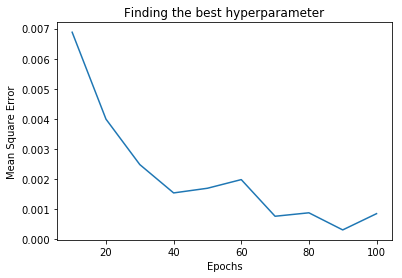

In [31]:
lists = sorted(epochs_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Epochs')
plt.ylabel('Mean Square Error')
plt.show()

12.3 Optimal number of neurons

In [12]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
epochs = 90
dropout = 0.3
neuronlist1 = [32, 64, 128, 256, 512]
neuronlist2 = [16, 32, 64]
neurons_result = {}

for neuron_lstm in neuronlist1:
    neurons = [neuron_lstm, neuron_lstm]
    for activation in neuronlist2:
        neurons.append(activation)
        neurons.append(1)
        trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs)
        neurons_result[str(neurons)] = testScore
        neurons = neurons[:2]    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 32)            4736      
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 32)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 17        
Total params: 13,601
Trainable params: 13,601
Non-trainable params: 0
_________________________________________________________________
Train 

13707/13707 [==============================] - 1s - loss: 3.7209e-04 - acc: 0.0000e+00 - val_loss: 3.4938e-04 - val_acc: 0.0000e+00
Epoch 8/90
13707/13707 [==============================] - 1s - loss: 3.3857e-04 - acc: 0.0000e+00 - val_loss: 2.8594e-04 - val_acc: 0.0000e+00
Epoch 9/90
13707/13707 [==============================] - 1s - loss: 3.3065e-04 - acc: 0.0000e+00 - val_loss: 3.7322e-04 - val_acc: 0.0000e+00
Epoch 10/90
13707/13707 [==============================] - 1s - loss: 3.1574e-04 - acc: 0.0000e+00 - val_loss: 2.4896e-04 - val_acc: 0.0000e+00
Epoch 11/90
13707/13707 [==============================] - 1s - loss: 3.0677e-04 - acc: 0.0000e+00 - val_loss: 2.3476e-04 - val_acc: 0.0000e+00
Epoch 12/90
13707/13707 [==============================] - 1s - loss: 3.1454e-04 - acc: 0.0000e+00 - val_loss: 2.1837e-04 - val_acc: 0.0000e+00
Epoch 13/90
13707/13707 [==============================] - 1s - loss: 3.3050e-04 - acc: 0.0000e+00 - val_loss: 2.3540e-04 - val_acc: 0.0000e+00
Epoch 

13707/13707 [==============================] - 1s - loss: 2.0121e-04 - acc: 0.0000e+00 - val_loss: 3.5531e-04 - val_acc: 0.0000e+00
Epoch 22/90
13707/13707 [==============================] - 1s - loss: 1.9814e-04 - acc: 0.0000e+00 - val_loss: 6.5135e-04 - val_acc: 0.0000e+00
Epoch 23/90
13707/13707 [==============================] - 1s - loss: 1.9455e-04 - acc: 0.0000e+00 - val_loss: 2.9765e-04 - val_acc: 0.0000e+00
Epoch 24/90
13707/13707 [==============================] - 1s - loss: 1.8654e-04 - acc: 0.0000e+00 - val_loss: 7.0856e-04 - val_acc: 0.0000e+00
Epoch 25/90
13707/13707 [==============================] - 1s - loss: 1.8610e-04 - acc: 0.0000e+00 - val_loss: 7.8086e-04 - val_acc: 0.0000e+00
Epoch 26/90
13707/13707 [==============================] - 1s - loss: 1.7281e-04 - acc: 0.0000e+00 - val_loss: 3.5580e-04 - val_acc: 0.0000e+00
Epoch 27/90
13707/13707 [==============================] - 1s - loss: 1.6975e-04 - acc: 0.0000e+00 - val_loss: 4.4894e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 1s - loss: 1.3955e-04 - acc: 0.0000e+00 - val_loss: 2.7510e-04 - val_acc: 0.0000e+00
Epoch 37/90
13707/13707 [==============================] - 1s - loss: 1.4510e-04 - acc: 0.0000e+00 - val_loss: 2.8844e-04 - val_acc: 0.0000e+00
Epoch 38/90
13707/13707 [==============================] - 1s - loss: 1.4596e-04 - acc: 0.0000e+00 - val_loss: 2.4819e-04 - val_acc: 0.0000e+00
Epoch 39/90
13707/13707 [==============================] - 1s - loss: 1.5197e-04 - acc: 0.0000e+00 - val_loss: 2.4457e-04 - val_acc: 0.0000e+00
Epoch 40/90
13707/13707 [==============================] - 1s - loss: 1.4812e-04 - acc: 0.0000e+00 - val_loss: 2.3604e-04 - val_acc: 0.0000e+00
Epoch 41/90
13707/13707 [==============================] - 1s - loss: 1.3879e-04 - acc: 0.0000e+00 - val_loss: 1.7850e-04 - val_acc: 0.0000e+00
Epoch 42/90
13707/13707 [==============================] - 1s - loss: 1.3658e-04 - acc: 0.0000e+00 - val_loss: 2.0768e-04 - val_acc: 0.0000e+00
Epoc

Train on 13707 samples, validate on 1523 samples
Epoch 1/90
13707/13707 [==============================] - 3s - loss: 0.0187 - acc: 0.0000e+00 - val_loss: 0.0053 - val_acc: 0.0000e+00
Epoch 2/90
13707/13707 [==============================] - 1s - loss: 8.0165e-04 - acc: 0.0000e+00 - val_loss: 8.2970e-04 - val_acc: 0.0000e+00
Epoch 3/90
13707/13707 [==============================] - 1s - loss: 3.7721e-04 - acc: 0.0000e+00 - val_loss: 7.6723e-04 - val_acc: 0.0000e+00
Epoch 4/90
13707/13707 [==============================] - 1s - loss: 2.8068e-04 - acc: 0.0000e+00 - val_loss: 7.3129e-04 - val_acc: 0.0000e+00
Epoch 5/90
13707/13707 [==============================] - 1s - loss: 2.3887e-04 - acc: 0.0000e+00 - val_loss: 2.6333e-04 - val_acc: 0.0000e+00
Epoch 6/90
13707/13707 [==============================] - 1s - loss: 1.9935e-04 - acc: 0.0000e+00 - val_loss: 2.4566e-04 - val_acc: 0.0000e+00
Epoch 7/90
13707/13707 [==============================] - 1s - loss: 2.0403e-04 - acc: 0.0000e+00 - v

13707/13707 [==============================] - 1s - loss: 1.5923e-04 - acc: 0.0000e+00 - val_loss: 2.2892e-04 - val_acc: 0.0000e+00
Epoch 16/90
13707/13707 [==============================] - 1s - loss: 1.5762e-04 - acc: 0.0000e+00 - val_loss: 2.4994e-04 - val_acc: 0.0000e+00
Epoch 17/90
13707/13707 [==============================] - 1s - loss: 1.5353e-04 - acc: 0.0000e+00 - val_loss: 5.3604e-04 - val_acc: 0.0000e+00
Epoch 18/90
13707/13707 [==============================] - 1s - loss: 1.5253e-04 - acc: 0.0000e+00 - val_loss: 2.1351e-04 - val_acc: 0.0000e+00
Epoch 19/90
13707/13707 [==============================] - 1s - loss: 1.4118e-04 - acc: 0.0000e+00 - val_loss: 2.1671e-04 - val_acc: 0.0000e+00
Epoch 20/90
13707/13707 [==============================] - 1s - loss: 1.4606e-04 - acc: 0.0000e+00 - val_loss: 2.3224e-04 - val_acc: 0.0000e+00
Epoch 21/90
13707/13707 [==============================] - 1s - loss: 1.4970e-04 - acc: 0.0000e+00 - val_loss: 2.0434e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 1s - loss: 1.3098e-04 - acc: 0.0000e+00 - val_loss: 2.8126e-04 - val_acc: 0.0000e+00
Epoch 30/90
13707/13707 [==============================] - 1s - loss: 1.0054e-04 - acc: 0.0000e+00 - val_loss: 1.8434e-04 - val_acc: 0.0000e+00
Epoch 31/90
13707/13707 [==============================] - 1s - loss: 1.0663e-04 - acc: 0.0000e+00 - val_loss: 1.9666e-04 - val_acc: 0.0000e+00
Epoch 32/90
13707/13707 [==============================] - 1s - loss: 1.0971e-04 - acc: 0.0000e+00 - val_loss: 4.8166e-04 - val_acc: 0.0000e+00
Epoch 33/90
13707/13707 [==============================] - 1s - loss: 1.0433e-04 - acc: 0.0000e+00 - val_loss: 1.7781e-04 - val_acc: 0.0000e+00
Epoch 34/90
13707/13707 [==============================] - 1s - loss: 1.0173e-04 - acc: 0.0000e+00 - val_loss: 1.7939e-04 - val_acc: 0.0000e+00
Epoch 35/90
13707/13707 [==============================] - 1s - loss: 1.0078e-04 - acc: 0.0000e+00 - val_loss: 3.4770e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 1s - loss: 8.3445e-05 - acc: 0.0000e+00 - val_loss: 1.5683e-04 - val_acc: 0.0000e+00
Epoch 44/90
13707/13707 [==============================] - 1s - loss: 8.4116e-05 - acc: 0.0000e+00 - val_loss: 1.5286e-04 - val_acc: 0.0000e+00
Epoch 45/90
13707/13707 [==============================] - 1s - loss: 9.4973e-05 - acc: 0.0000e+00 - val_loss: 1.5757e-04 - val_acc: 0.0000e+00
Epoch 46/90
13707/13707 [==============================] - 1s - loss: 9.8143e-05 - acc: 0.0000e+00 - val_loss: 2.6552e-04 - val_acc: 0.0000e+00
Epoch 47/90
13707/13707 [==============================] - 1s - loss: 9.6381e-05 - acc: 0.0000e+00 - val_loss: 1.6570e-04 - val_acc: 0.0000e+00
Epoch 48/90
13707/13707 [==============================] - 1s - loss: 1.0738e-04 - acc: 0.0000e+00 - val_loss: 2.0487e-04 - val_acc: 0.0000e+00
Epoch 49/90
13707/13707 [==============================] - 1s - loss: 8.9032e-05 - acc: 0.0000e+00 - val_loss: 1.4960e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 1s - loss: 7.5439e-05 - acc: 0.0000e+00 - val_loss: 1.3558e-04 - val_acc: 0.0000e+00
Epoch 59/90
13707/13707 [==============================] - 1s - loss: 7.2382e-05 - acc: 0.0000e+00 - val_loss: 3.6089e-04 - val_acc: 0.0000e+00
Epoch 60/90
13707/13707 [==============================] - 1s - loss: 7.7982e-05 - acc: 0.0000e+00 - val_loss: 2.9310e-04 - val_acc: 0.0000e+00
Epoch 61/90
13707/13707 [==============================] - 1s - loss: 7.6975e-05 - acc: 0.0000e+00 - val_loss: 1.8401e-04 - val_acc: 0.0000e+00
Epoch 62/90
13707/13707 [==============================] - 1s - loss: 8.7190e-05 - acc: 0.0000e+00 - val_loss: 1.7782e-04 - val_acc: 0.0000e+00
Epoch 63/90
13707/13707 [==============================] - 1s - loss: 7.5438e-05 - acc: 0.0000e+00 - val_loss: 1.5962e-04 - val_acc: 0.0000e+00
Epoch 64/90
13707/13707 [==============================] - 1s - loss: 8.1334e-05 - acc: 0.0000e+00 - val_loss: 2.3654e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 5.8937e-05 - acc: 0.0000e+00 - val_loss: 1.1271e-04 - val_acc: 0.0000e+00
Epoch 73/90
13707/13707 [==============================] - 2s - loss: 6.1963e-05 - acc: 0.0000e+00 - val_loss: 1.3947e-04 - val_acc: 0.0000e+00
Epoch 74/90
13707/13707 [==============================] - 2s - loss: 5.4133e-05 - acc: 0.0000e+00 - val_loss: 1.1294e-04 - val_acc: 0.0000e+00
Epoch 75/90
13707/13707 [==============================] - 2s - loss: 5.8761e-05 - acc: 0.0000e+00 - val_loss: 1.1375e-04 - val_acc: 0.0000e+00
Epoch 76/90
13707/13707 [==============================] - 2s - loss: 4.8949e-05 - acc: 0.0000e+00 - val_loss: 1.0669e-04 - val_acc: 0.0000e+00
Epoch 77/90
13707/13707 [==============================] - 2s - loss: 5.7898e-05 - acc: 0.0000e+00 - val_loss: 2.4619e-04 - val_acc: 0.0000e+00
Epoch 78/90
13707/13707 [==============================] - 2s - loss: 5.8353e-05 - acc: 0.0000e+00 - val_loss: 1.1384e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 4.6763e-05 - acc: 0.0000e+00 - val_loss: 1.0595e-04 - val_acc: 0.0000e+00
Epoch 87/90
13707/13707 [==============================] - 2s - loss: 5.0788e-05 - acc: 0.0000e+00 - val_loss: 1.5208e-04 - val_acc: 0.0000e+00
Epoch 88/90
13707/13707 [==============================] - 2s - loss: 5.0592e-05 - acc: 0.0000e+00 - val_loss: 1.0276e-04 - val_acc: 0.0000e+00
Epoch 89/90
13707/13707 [==============================] - 2s - loss: 5.5310e-05 - acc: 0.0000e+00 - val_loss: 1.6509e-04 - val_acc: 0.0000e+00
Epoch 90/90
13707/13707 [==============================] - 2s - loss: 4.6720e-05 - acc: 0.0000e+00 - val_loss: 1.3959e-04 - val_acc: 0.0000e+00
Train Score: 0.00003 MSE (0.01 RMSE)
Test Score: 0.00021 MSE (0.01 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_23 (LSTM)               (None, 22, 256)           267264    
_____________________

13707/13707 [==============================] - 5s - loss: 1.7744e-04 - acc: 0.0000e+00 - val_loss: 3.4495e-04 - val_acc: 0.0000e+00
Epoch 3/90
13707/13707 [==============================] - 5s - loss: 9.2383e-05 - acc: 0.0000e+00 - val_loss: 3.1878e-04 - val_acc: 0.0000e+00
Epoch 4/90
13707/13707 [==============================] - 5s - loss: 8.8010e-05 - acc: 0.0000e+00 - val_loss: 5.9432e-04 - val_acc: 0.0000e+00
Epoch 5/90
13707/13707 [==============================] - 5s - loss: 8.6156e-05 - acc: 0.0000e+00 - val_loss: 2.6485e-04 - val_acc: 0.0000e+00
Epoch 6/90
13707/13707 [==============================] - 5s - loss: 9.8003e-05 - acc: 0.0000e+00 - val_loss: 3.1075e-04 - val_acc: 0.0000e+00
Epoch 7/90
13707/13707 [==============================] - 5s - loss: 9.6360e-05 - acc: 0.0000e+00 - val_loss: 3.4285e-04 - val_acc: 0.0000e+00
Epoch 8/90
13707/13707 [==============================] - 5s - loss: 8.0516e-05 - acc: 0.0000e+00 - val_loss: 3.9601e-04 - val_acc: 0.0000e+00
Epoch 9/90

13707/13707 [==============================] - 5s - loss: 5.0257e-05 - acc: 0.0000e+00 - val_loss: 1.1430e-04 - val_acc: 0.0000e+00
Epoch 60/90
13707/13707 [==============================] - 5s - loss: 4.0646e-05 - acc: 0.0000e+00 - val_loss: 1.9424e-04 - val_acc: 0.0000e+00
Epoch 61/90
13707/13707 [==============================] - 5s - loss: 5.6332e-05 - acc: 0.0000e+00 - val_loss: 7.3764e-04 - val_acc: 0.0000e+00
Epoch 62/90
13707/13707 [==============================] - 5s - loss: 5.5294e-05 - acc: 0.0000e+00 - val_loss: 1.1102e-04 - val_acc: 0.0000e+00
Epoch 63/90
13707/13707 [==============================] - 5s - loss: 4.0142e-05 - acc: 0.0000e+00 - val_loss: 4.0685e-04 - val_acc: 0.0000e+00
Epoch 64/90
13707/13707 [==============================] - 5s - loss: 5.0925e-05 - acc: 0.0000e+00 - val_loss: 1.3003e-04 - val_acc: 0.0000e+00
Epoch 65/90
13707/13707 [==============================] - 5s - loss: 5.4738e-05 - acc: 0.0000e+00 - val_loss: 1.0553e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 5s - loss: 4.6059e-05 - acc: 0.0000e+00 - val_loss: 2.6171e-04 - val_acc: 0.0000e+00
Epoch 74/90
13707/13707 [==============================] - 5s - loss: 4.2302e-05 - acc: 0.0000e+00 - val_loss: 1.0281e-04 - val_acc: 0.0000e+00
Epoch 75/90
13707/13707 [==============================] - 5s - loss: 4.0051e-05 - acc: 0.0000e+00 - val_loss: 1.1258e-04 - val_acc: 0.0000e+00
Epoch 76/90
13707/13707 [==============================] - 5s - loss: 6.0282e-05 - acc: 0.0000e+00 - val_loss: 1.8706e-04 - val_acc: 0.0000e+00
Epoch 77/90
13707/13707 [==============================] - 5s - loss: 4.0816e-05 - acc: 0.0000e+00 - val_loss: 1.0030e-04 - val_acc: 0.0000e+00
Epoch 78/90
13707/13707 [==============================] - 5s - loss: 4.3881e-05 - acc: 0.0000e+00 - val_loss: 3.4460e-04 - val_acc: 0.0000e+00
Epoch 79/90
13707/13707 [==============================] - 5s - loss: 4.6086e-05 - acc: 0.0000e+00 - val_loss: 1.7175e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 5s - loss: 4.5288e-05 - acc: 0.0000e+00 - val_loss: 1.2911e-04 - val_acc: 0.0000e+00
Epoch 88/90
13707/13707 [==============================] - 5s - loss: 3.6853e-05 - acc: 0.0000e+00 - val_loss: 1.0088e-04 - val_acc: 0.0000e+00
Epoch 89/90
13707/13707 [==============================] - 5s - loss: 3.5433e-05 - acc: 0.0000e+00 - val_loss: 1.4986e-04 - val_acc: 0.0000e+00
Epoch 90/90
13707/13707 [==============================] - 5s - loss: 4.2263e-05 - acc: 0.0000e+00 - val_loss: 4.1180e-04 - val_acc: 0.0000e+00
Train Score: 0.00009 MSE (0.01 RMSE)
Test Score: 0.00176 MSE (0.04 RMSE)


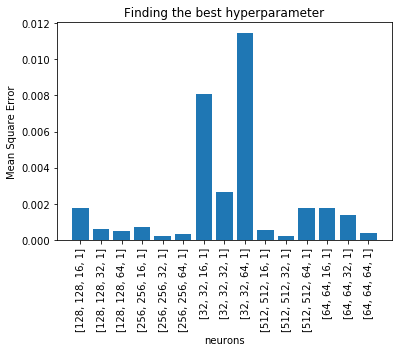

In [14]:
lists = sorted(neurons_result.items())
x,y = zip(*lists)

plt.title('Finding the best hyperparameter')
plt.xlabel('neurons')
plt.ylabel('Mean Square Error')

plt.bar(range(len(lists)), y, align='center')
plt.xticks(range(len(lists)), x)
plt.xticks(rotation=90)

plt.show()

12.4 Optimial Dropout value

In [14]:
stock_name = '^GSPC'
seq_len = 22
shape = [4, seq_len, 1] # feature, window, output
neurons = [256, 256, 32, 1]
epochs = 90
decaylist = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

In [12]:
def build_model3(layers, neurons, d, decay):
    model = Sequential()
    
    model.add(LSTM(neurons[0], input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(neurons[1], input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(neurons[2],kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(neurons[3],kernel_initializer="uniform",activation='linear'))
    # model = load_model('my_LSTM_stock_model1000.h5')
    adam = keras.optimizers.Adam(decay=decay)
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    model.summary()
    return model

In [13]:
def quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay):
    df = get_stock_data(stock_name)
    X_train, y_train, X_test, y_test = load_data(df, seq_len)
    model = build_model3(shape, neurons, d, decay)
    model.fit(X_train, y_train, batch_size=512, epochs=epochs, validation_split=0.1, verbose=1)
    # model.save('LSTM_Stock_prediction-20170429.h5')
    trainScore, testScore = model_score(model, X_train, y_train, X_test, y_test)
    return trainScore, testScore

In [15]:
decay_result = {}

for decay in decaylist:    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    decay_result[decay] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 22, 256)           267264    
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 256)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 256)               525312    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                8224      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
_________________________________________________________________
Trai

13707/13707 [==============================] - 2s - loss: 7.5814e-05 - acc: 0.0000e+00 - val_loss: 2.4876e-04 - val_acc: 0.0000e+00
Epoch 50/90
13707/13707 [==============================] - 2s - loss: 8.9445e-05 - acc: 0.0000e+00 - val_loss: 3.8789e-04 - val_acc: 0.0000e+00
Epoch 51/90
13707/13707 [==============================] - 2s - loss: 6.1836e-05 - acc: 0.0000e+00 - val_loss: 1.5367e-04 - val_acc: 0.0000e+00
Epoch 52/90
13707/13707 [==============================] - 2s - loss: 6.3926e-05 - acc: 0.0000e+00 - val_loss: 2.7854e-04 - val_acc: 0.0000e+00
Epoch 53/90
13707/13707 [==============================] - 2s - loss: 6.6929e-05 - acc: 0.0000e+00 - val_loss: 1.4532e-04 - val_acc: 0.0000e+00
Epoch 54/90
13707/13707 [==============================] - 2s - loss: 6.3945e-05 - acc: 0.0000e+00 - val_loss: 1.7865e-04 - val_acc: 0.0000e+00
Epoch 55/90
13707/13707 [==============================] - 2s - loss: 6.7463e-05 - acc: 0.0000e+00 - val_loss: 2.3209e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 1.0138e-04 - acc: 0.0000e+00 - val_loss: 3.7100e-04 - val_acc: 0.0000e+00
Epoch 8/90
13707/13707 [==============================] - 2s - loss: 9.2695e-05 - acc: 0.0000e+00 - val_loss: 2.4905e-04 - val_acc: 0.0000e+00
Epoch 9/90
13707/13707 [==============================] - 2s - loss: 9.6153e-05 - acc: 0.0000e+00 - val_loss: 3.3920e-04 - val_acc: 0.0000e+00
Epoch 10/90
13707/13707 [==============================] - 2s - loss: 1.0700e-04 - acc: 0.0000e+00 - val_loss: 7.5708e-04 - val_acc: 0.0000e+00
Epoch 11/90
13707/13707 [==============================] - 2s - loss: 1.0424e-04 - acc: 0.0000e+00 - val_loss: 2.3749e-04 - val_acc: 0.0000e+00
Epoch 12/90
13707/13707 [==============================] - 2s - loss: 8.9004e-05 - acc: 0.0000e+00 - val_loss: 2.8443e-04 - val_acc: 0.0000e+00
Epoch 13/90
13707/13707 [==============================] - 2s - loss: 9.0934e-05 - acc: 0.0000e+00 - val_loss: 2.3463e-04 - val_acc: 0.0000e+00
Epoch 

13707/13707 [==============================] - 2s - loss: 5.5197e-05 - acc: 0.0000e+00 - val_loss: 1.2746e-04 - val_acc: 0.0000e+00
Epoch 64/90
13707/13707 [==============================] - 2s - loss: 5.8607e-05 - acc: 0.0000e+00 - val_loss: 2.8203e-04 - val_acc: 0.0000e+00
Epoch 65/90
13707/13707 [==============================] - 2s - loss: 7.3751e-05 - acc: 0.0000e+00 - val_loss: 3.4747e-04 - val_acc: 0.0000e+00
Epoch 66/90
13707/13707 [==============================] - 2s - loss: 7.1687e-05 - acc: 0.0000e+00 - val_loss: 1.3186e-04 - val_acc: 0.0000e+00
Epoch 67/90
13707/13707 [==============================] - 2s - loss: 6.9851e-05 - acc: 0.0000e+00 - val_loss: 4.4105e-04 - val_acc: 0.0000e+00
Epoch 68/90
13707/13707 [==============================] - 2s - loss: 8.7404e-05 - acc: 0.0000e+00 - val_loss: 1.2459e-04 - val_acc: 0.0000e+00
Epoch 69/90
13707/13707 [==============================] - 2s - loss: 5.3114e-05 - acc: 0.0000e+00 - val_loss: 1.1743e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 8.5093e-05 - acc: 0.0000e+00 - val_loss: 3.8989e-04 - val_acc: 0.0000e+00
Epoch 22/90
13707/13707 [==============================] - 2s - loss: 8.2774e-05 - acc: 0.0000e+00 - val_loss: 1.8704e-04 - val_acc: 0.0000e+00
Epoch 23/90
13707/13707 [==============================] - 2s - loss: 7.3514e-05 - acc: 0.0000e+00 - val_loss: 1.8411e-04 - val_acc: 0.0000e+00
Epoch 24/90
13707/13707 [==============================] - 2s - loss: 1.0534e-04 - acc: 0.0000e+00 - val_loss: 2.6722e-04 - val_acc: 0.0000e+00
Epoch 25/90
13707/13707 [==============================] - 2s - loss: 6.9454e-05 - acc: 0.0000e+00 - val_loss: 3.2659e-04 - val_acc: 0.0000e+00
Epoch 26/90
13707/13707 [==============================] - 2s - loss: 6.8341e-05 - acc: 0.0000e+00 - val_loss: 2.2177e-04 - val_acc: 0.0000e+00
Epoch 27/90
13707/13707 [==============================] - 2s - loss: 7.5278e-05 - acc: 0.0000e+00 - val_loss: 1.7510e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 5.5157e-05 - acc: 0.0000e+00 - val_loss: 2.2662e-04 - val_acc: 0.0000e+00
Epoch 78/90
13707/13707 [==============================] - 2s - loss: 5.5886e-05 - acc: 0.0000e+00 - val_loss: 1.4599e-04 - val_acc: 0.0000e+00
Epoch 79/90
13707/13707 [==============================] - 2s - loss: 6.0130e-05 - acc: 0.0000e+00 - val_loss: 2.3498e-04 - val_acc: 0.0000e+00
Epoch 80/90
13707/13707 [==============================] - 2s - loss: 5.4722e-05 - acc: 0.0000e+00 - val_loss: 9.9896e-05 - val_acc: 0.0000e+00
Epoch 81/90
13707/13707 [==============================] - 2s - loss: 5.2930e-05 - acc: 0.0000e+00 - val_loss: 1.5012e-04 - val_acc: 0.0000e+00
Epoch 82/90
13707/13707 [==============================] - 2s - loss: 5.5249e-05 - acc: 0.0000e+00 - val_loss: 9.8496e-05 - val_acc: 0.0000e+00
Epoch 83/90
13707/13707 [==============================] - 2s - loss: 6.6249e-05 - acc: 0.0000e+00 - val_loss: 2.2127e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 7.1747e-05 - acc: 0.0000e+00 - val_loss: 3.3410e-04 - val_acc: 0.0000e+00
Epoch 36/90
13707/13707 [==============================] - 2s - loss: 7.7700e-05 - acc: 0.0000e+00 - val_loss: 1.6883e-04 - val_acc: 0.0000e+00
Epoch 37/90
13707/13707 [==============================] - 2s - loss: 7.0560e-05 - acc: 0.0000e+00 - val_loss: 2.5049e-04 - val_acc: 0.0000e+00
Epoch 38/90
13707/13707 [==============================] - 2s - loss: 6.6507e-05 - acc: 0.0000e+00 - val_loss: 1.7083e-04 - val_acc: 0.0000e+00
Epoch 39/90
13707/13707 [==============================] - 2s - loss: 7.3928e-05 - acc: 0.0000e+00 - val_loss: 1.9526e-04 - val_acc: 0.0000e+00
Epoch 40/90
13707/13707 [==============================] - 2s - loss: 7.2799e-05 - acc: 0.0000e+00 - val_loss: 1.5929e-04 - val_acc: 0.0000e+00
Epoch 41/90
13707/13707 [==============================] - 2s - loss: 6.6002e-05 - acc: 0.0000e+00 - val_loss: 2.3309e-04 - val_acc: 0.0000e+00
Epoc

Train on 13707 samples, validate on 1523 samples
Epoch 1/90
13707/13707 [==============================] - 4s - loss: 0.0087 - acc: 0.0000e+00 - val_loss: 0.0037 - val_acc: 0.0000e+00
Epoch 2/90
13707/13707 [==============================] - 2s - loss: 5.1415e-04 - acc: 0.0000e+00 - val_loss: 8.5366e-04 - val_acc: 0.0000e+00
Epoch 3/90
13707/13707 [==============================] - 2s - loss: 1.7658e-04 - acc: 0.0000e+00 - val_loss: 5.3417e-04 - val_acc: 0.0000e+00
Epoch 4/90
13707/13707 [==============================] - 2s - loss: 1.2861e-04 - acc: 0.0000e+00 - val_loss: 3.5525e-04 - val_acc: 0.0000e+00
Epoch 5/90
13707/13707 [==============================] - 2s - loss: 1.0391e-04 - acc: 0.0000e+00 - val_loss: 3.0271e-04 - val_acc: 0.0000e+00
Epoch 6/90
13707/13707 [==============================] - 2s - loss: 1.0041e-04 - acc: 0.0000e+00 - val_loss: 2.7384e-04 - val_acc: 0.0000e+00
Epoch 7/90
13707/13707 [==============================] - 2s - loss: 9.3974e-05 - acc: 0.0000e+00 - v

13707/13707 [==============================] - 2s - loss: 5.7924e-05 - acc: 0.0000e+00 - val_loss: 1.3883e-04 - val_acc: 0.0000e+00
Epoch 58/90
13707/13707 [==============================] - 2s - loss: 6.0982e-05 - acc: 0.0000e+00 - val_loss: 1.2470e-04 - val_acc: 0.0000e+00
Epoch 59/90
13707/13707 [==============================] - 2s - loss: 6.4123e-05 - acc: 0.0000e+00 - val_loss: 3.0393e-04 - val_acc: 0.0000e+00
Epoch 60/90
13707/13707 [==============================] - 2s - loss: 6.0255e-05 - acc: 0.0000e+00 - val_loss: 1.2217e-04 - val_acc: 0.0000e+00
Epoch 61/90
13707/13707 [==============================] - 2s - loss: 7.0869e-05 - acc: 0.0000e+00 - val_loss: 2.9455e-04 - val_acc: 0.0000e+00
Epoch 62/90
13707/13707 [==============================] - 2s - loss: 7.3115e-05 - acc: 0.0000e+00 - val_loss: 4.5479e-04 - val_acc: 0.0000e+00
Epoch 63/90
13707/13707 [==============================] - 2s - loss: 5.8738e-05 - acc: 0.0000e+00 - val_loss: 1.2865e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 8.4456e-05 - acc: 0.0000e+00 - val_loss: 2.3465e-04 - val_acc: 0.0000e+00
Epoch 16/90
13707/13707 [==============================] - 2s - loss: 1.1257e-04 - acc: 0.0000e+00 - val_loss: 4.1878e-04 - val_acc: 0.0000e+00
Epoch 17/90
13707/13707 [==============================] - 2s - loss: 1.0567e-04 - acc: 0.0000e+00 - val_loss: 4.0021e-04 - val_acc: 0.0000e+00
Epoch 18/90
13707/13707 [==============================] - 2s - loss: 8.5394e-05 - acc: 0.0000e+00 - val_loss: 4.3484e-04 - val_acc: 0.0000e+00
Epoch 19/90
13707/13707 [==============================] - 2s - loss: 9.7117e-05 - acc: 0.0000e+00 - val_loss: 2.1213e-04 - val_acc: 0.0000e+00
Epoch 20/90
13707/13707 [==============================] - 2s - loss: 8.6638e-05 - acc: 0.0000e+00 - val_loss: 2.6007e-04 - val_acc: 0.0000e+00
Epoch 21/90
13707/13707 [==============================] - 2s - loss: 7.8425e-05 - acc: 0.0000e+00 - val_loss: 1.9956e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 5.4285e-05 - acc: 0.0000e+00 - val_loss: 1.0557e-04 - val_acc: 0.0000e+00
Epoch 73/90
13707/13707 [==============================] - 2s - loss: 5.2575e-05 - acc: 0.0000e+00 - val_loss: 1.2703e-04 - val_acc: 0.0000e+00
Epoch 74/90
13707/13707 [==============================] - 2s - loss: 5.7853e-05 - acc: 0.0000e+00 - val_loss: 3.2244e-04 - val_acc: 0.0000e+00
Epoch 75/90
13707/13707 [==============================] - 2s - loss: 4.9638e-05 - acc: 0.0000e+00 - val_loss: 1.1982e-04 - val_acc: 0.0000e+00
Epoch 76/90
13707/13707 [==============================] - 2s - loss: 6.3540e-05 - acc: 0.0000e+00 - val_loss: 1.8460e-04 - val_acc: 0.0000e+00
Epoch 77/90
13707/13707 [==============================] - 2s - loss: 6.0959e-05 - acc: 0.0000e+00 - val_loss: 1.7797e-04 - val_acc: 0.0000e+00
Epoch 78/90
13707/13707 [==============================] - 2s - loss: 5.2776e-05 - acc: 0.0000e+00 - val_loss: 1.2487e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 7.4977e-05 - acc: 0.0000e+00 - val_loss: 2.3587e-04 - val_acc: 0.0000e+00
Epoch 31/90
13707/13707 [==============================] - 2s - loss: 6.9825e-05 - acc: 0.0000e+00 - val_loss: 1.9400e-04 - val_acc: 0.0000e+00
Epoch 32/90
13707/13707 [==============================] - 2s - loss: 7.9258e-05 - acc: 0.0000e+00 - val_loss: 1.8559e-04 - val_acc: 0.0000e+00
Epoch 33/90
13707/13707 [==============================] - 2s - loss: 1.1830e-04 - acc: 0.0000e+00 - val_loss: 8.1235e-04 - val_acc: 0.0000e+00
Epoch 34/90
13707/13707 [==============================] - 2s - loss: 8.8482e-05 - acc: 0.0000e+00 - val_loss: 4.1811e-04 - val_acc: 0.0000e+00
Epoch 35/90
13707/13707 [==============================] - 2s - loss: 9.9037e-05 - acc: 0.0000e+00 - val_loss: 1.6783e-04 - val_acc: 0.0000e+00
Epoch 36/90
13707/13707 [==============================] - 2s - loss: 8.4977e-05 - acc: 0.0000e+00 - val_loss: 2.3832e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 4.9125e-05 - acc: 0.0000e+00 - val_loss: 9.9087e-05 - val_acc: 0.0000e+00
Epoch 87/90
13707/13707 [==============================] - 2s - loss: 5.2275e-05 - acc: 0.0000e+00 - val_loss: 1.2411e-04 - val_acc: 0.0000e+00
Epoch 88/90
13707/13707 [==============================] - 2s - loss: 5.7377e-05 - acc: 0.0000e+00 - val_loss: 9.6935e-05 - val_acc: 0.0000e+00
Epoch 89/90
13707/13707 [==============================] - 2s - loss: 4.8645e-05 - acc: 0.0000e+00 - val_loss: 1.1367e-04 - val_acc: 0.0000e+00
Epoch 90/90
13707/13707 [==============================] - 2s - loss: 5.0339e-05 - acc: 0.0000e+00 - val_loss: 9.9187e-05 - val_acc: 0.0000e+00
Train Score: 0.00002 MSE (0.00 RMSE)
Test Score: 0.00032 MSE (0.02 RMSE)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 22, 256)           267264    
_____________________

13707/13707 [==============================] - 2s - loss: 6.1227e-05 - acc: 0.0000e+00 - val_loss: 2.7145e-04 - val_acc: 0.0000e+00
Epoch 45/90
13707/13707 [==============================] - 2s - loss: 5.9630e-05 - acc: 0.0000e+00 - val_loss: 1.7365e-04 - val_acc: 0.0000e+00
Epoch 46/90
13707/13707 [==============================] - 2s - loss: 5.8065e-05 - acc: 0.0000e+00 - val_loss: 2.1107e-04 - val_acc: 0.0000e+00
Epoch 47/90
13707/13707 [==============================] - 2s - loss: 6.7750e-05 - acc: 0.0000e+00 - val_loss: 2.8291e-04 - val_acc: 0.0000e+00
Epoch 48/90
13707/13707 [==============================] - 2s - loss: 7.2271e-05 - acc: 0.0000e+00 - val_loss: 1.2929e-04 - val_acc: 0.0000e+00
Epoch 49/90
13707/13707 [==============================] - 2s - loss: 5.6445e-05 - acc: 0.0000e+00 - val_loss: 1.2971e-04 - val_acc: 0.0000e+00
Epoch 50/90
13707/13707 [==============================] - 2s - loss: 5.7389e-05 - acc: 0.0000e+00 - val_loss: 1.2242e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 5.8312e-04 - acc: 0.0000e+00 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 3/90
13707/13707 [==============================] - 2s - loss: 1.8926e-04 - acc: 0.0000e+00 - val_loss: 5.6433e-04 - val_acc: 0.0000e+00
Epoch 4/90
13707/13707 [==============================] - 2s - loss: 1.1808e-04 - acc: 0.0000e+00 - val_loss: 2.7698e-04 - val_acc: 0.0000e+00
Epoch 5/90
13707/13707 [==============================] - 2s - loss: 1.0705e-04 - acc: 0.0000e+00 - val_loss: 2.5206e-04 - val_acc: 0.0000e+00
Epoch 6/90
13707/13707 [==============================] - 2s - loss: 9.6845e-05 - acc: 0.0000e+00 - val_loss: 2.4755e-04 - val_acc: 0.0000e+00
Epoch 7/90
13707/13707 [==============================] - 2s - loss: 1.0041e-04 - acc: 0.0000e+00 - val_loss: 2.5016e-04 - val_acc: 0.0000e+00
Epoch 8/90
13707/13707 [==============================] - 2s - loss: 9.7657e-05 - acc: 0.0000e+00 - val_loss: 4.1486e-04 - val_acc: 0.0000e+00
Epoch 9/90
137

13707/13707 [==============================] - 2s - loss: 6.1030e-05 - acc: 0.0000e+00 - val_loss: 1.7050e-04 - val_acc: 0.0000e+00
Epoch 60/90
13707/13707 [==============================] - 2s - loss: 5.7863e-05 - acc: 0.0000e+00 - val_loss: 1.4728e-04 - val_acc: 0.0000e+00
Epoch 61/90
13707/13707 [==============================] - 2s - loss: 6.3282e-05 - acc: 0.0000e+00 - val_loss: 1.7243e-04 - val_acc: 0.0000e+00
Epoch 62/90
13707/13707 [==============================] - 2s - loss: 5.9349e-05 - acc: 0.0000e+00 - val_loss: 3.6039e-04 - val_acc: 0.0000e+00
Epoch 63/90
13707/13707 [==============================] - 2s - loss: 6.9651e-05 - acc: 0.0000e+00 - val_loss: 2.0825e-04 - val_acc: 0.0000e+00
Epoch 64/90
13707/13707 [==============================] - 2s - loss: 7.0597e-05 - acc: 0.0000e+00 - val_loss: 1.2898e-04 - val_acc: 0.0000e+00
Epoch 65/90
13707/13707 [==============================] - 2s - loss: 6.2718e-05 - acc: 0.0000e+00 - val_loss: 1.4828e-04 - val_acc: 0.0000e+00
Epoc

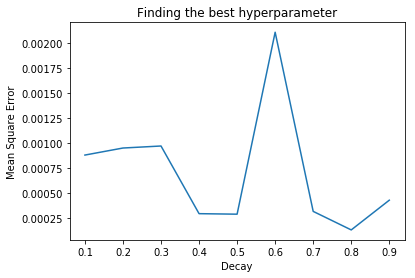

In [16]:
lists = sorted(decay_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Decay')
plt.ylabel('Mean Square Error')
plt.show()

In [27]:
stock_name = '^GSPC'
neurons = [256, 256, 32, 1]
epochs = 90
d = 0.3 #dropout
decay = 0.4

In [28]:
seq_len_list = [5, 10, 22, 60, 120, 180]

seq_len_result = {}

for seq_len in seq_len_list:
    shape = [4, seq_len, 1]
    
    trainScore, testScore = quick_measure(stock_name, seq_len, d, shape, neurons, epochs, decay)
    seq_len_result[seq_len] = testScore

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_25 (LSTM)               (None, 5, 256)            267264    
_________________________________________________________________
dropout_25 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
lstm_26 (LSTM)               (None, 256)               525312    
_________________________________________________________________
dropout_26 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_25 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 33        
Total params: 800,833
Trainable params: 800,833
Non-trainable params: 0
_________________________________________________________________
Trai

13720/13720 [==============================] - 0s - loss: 6.4705e-05 - acc: 0.0000e+00 - val_loss: 1.1223e-04 - val_acc: 0.0000e+00
Epoch 50/90
13720/13720 [==============================] - 0s - loss: 6.5480e-05 - acc: 0.0000e+00 - val_loss: 1.3953e-04 - val_acc: 0.0000e+00
Epoch 51/90
13720/13720 [==============================] - 0s - loss: 5.8361e-05 - acc: 0.0000e+00 - val_loss: 1.6859e-04 - val_acc: 0.0000e+00
Epoch 52/90
13720/13720 [==============================] - 0s - loss: 5.7276e-05 - acc: 0.0000e+00 - val_loss: 1.1123e-04 - val_acc: 0.0000e+00
Epoch 53/90
13720/13720 [==============================] - 0s - loss: 5.8302e-05 - acc: 0.0000e+00 - val_loss: 1.8325e-04 - val_acc: 0.0000e+00
Epoch 54/90
13720/13720 [==============================] - 0s - loss: 5.7336e-05 - acc: 0.0000e+00 - val_loss: 1.1708e-04 - val_acc: 0.0000e+00
Epoch 55/90
13720/13720 [==============================] - 0s - loss: 5.0876e-05 - acc: 0.0000e+00 - val_loss: 1.2762e-04 - val_acc: 0.0000e+00
Epoc

13716/13716 [==============================] - 1s - loss: 9.1310e-05 - acc: 0.0000e+00 - val_loss: 2.2097e-04 - val_acc: 0.0000e+00
Epoch 8/90
13716/13716 [==============================] - 1s - loss: 9.1000e-05 - acc: 0.0000e+00 - val_loss: 2.0048e-04 - val_acc: 0.0000e+00
Epoch 9/90
13716/13716 [==============================] - 1s - loss: 8.6275e-05 - acc: 0.0000e+00 - val_loss: 1.8437e-04 - val_acc: 0.0000e+00
Epoch 10/90
13716/13716 [==============================] - 1s - loss: 8.0305e-05 - acc: 0.0000e+00 - val_loss: 1.8771e-04 - val_acc: 0.0000e+00
Epoch 11/90
13716/13716 [==============================] - 1s - loss: 7.9185e-05 - acc: 0.0000e+00 - val_loss: 2.4136e-04 - val_acc: 0.0000e+00
Epoch 12/90
13716/13716 [==============================] - 1s - loss: 8.5153e-05 - acc: 0.0000e+00 - val_loss: 4.1757e-04 - val_acc: 0.0000e+00
Epoch 13/90
13716/13716 [==============================] - 1s - loss: 8.9859e-05 - acc: 0.0000e+00 - val_loss: 1.8177e-04 - val_acc: 0.0000e+00
Epoch 

13716/13716 [==============================] - 1s - loss: 5.9701e-05 - acc: 0.0000e+00 - val_loss: 1.3881e-04 - val_acc: 0.0000e+00
Epoch 64/90
13716/13716 [==============================] - 1s - loss: 5.5470e-05 - acc: 0.0000e+00 - val_loss: 1.3168e-04 - val_acc: 0.0000e+00
Epoch 65/90
13716/13716 [==============================] - 1s - loss: 5.7555e-05 - acc: 0.0000e+00 - val_loss: 1.5070e-04 - val_acc: 0.0000e+00
Epoch 66/90
13716/13716 [==============================] - 1s - loss: 5.7928e-05 - acc: 0.0000e+00 - val_loss: 1.5600e-04 - val_acc: 0.0000e+00
Epoch 67/90
13716/13716 [==============================] - 1s - loss: 5.7025e-05 - acc: 0.0000e+00 - val_loss: 1.3148e-04 - val_acc: 0.0000e+00
Epoch 68/90
13716/13716 [==============================] - 1s - loss: 5.8403e-05 - acc: 0.0000e+00 - val_loss: 1.7163e-04 - val_acc: 0.0000e+00
Epoch 69/90
13716/13716 [==============================] - 1s - loss: 6.5568e-05 - acc: 0.0000e+00 - val_loss: 1.7475e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 8.3109e-05 - acc: 0.0000e+00 - val_loss: 2.0343e-04 - val_acc: 0.0000e+00
Epoch 22/90
13707/13707 [==============================] - 2s - loss: 7.2431e-05 - acc: 0.0000e+00 - val_loss: 1.9113e-04 - val_acc: 0.0000e+00
Epoch 23/90
13707/13707 [==============================] - 2s - loss: 8.1796e-05 - acc: 0.0000e+00 - val_loss: 4.9820e-04 - val_acc: 0.0000e+00
Epoch 24/90
13707/13707 [==============================] - 2s - loss: 7.7776e-05 - acc: 0.0000e+00 - val_loss: 8.7579e-04 - val_acc: 0.0000e+00
Epoch 25/90
13707/13707 [==============================] - 2s - loss: 1.0819e-04 - acc: 0.0000e+00 - val_loss: 2.2275e-04 - val_acc: 0.0000e+00
Epoch 26/90
13707/13707 [==============================] - 2s - loss: 8.0869e-05 - acc: 0.0000e+00 - val_loss: 2.5468e-04 - val_acc: 0.0000e+00
Epoch 27/90
13707/13707 [==============================] - 2s - loss: 8.7399e-05 - acc: 0.0000e+00 - val_loss: 3.6695e-04 - val_acc: 0.0000e+00
Epoc

13707/13707 [==============================] - 2s - loss: 5.3151e-05 - acc: 0.0000e+00 - val_loss: 1.5398e-04 - val_acc: 0.0000e+00
Epoch 78/90
13707/13707 [==============================] - 2s - loss: 5.4668e-05 - acc: 0.0000e+00 - val_loss: 1.0647e-04 - val_acc: 0.0000e+00
Epoch 79/90
13707/13707 [==============================] - 2s - loss: 5.4110e-05 - acc: 0.0000e+00 - val_loss: 1.7840e-04 - val_acc: 0.0000e+00
Epoch 80/90
13707/13707 [==============================] - 2s - loss: 6.2869e-05 - acc: 0.0000e+00 - val_loss: 1.6193e-04 - val_acc: 0.0000e+00
Epoch 81/90
13707/13707 [==============================] - 2s - loss: 5.7827e-05 - acc: 0.0000e+00 - val_loss: 1.2444e-04 - val_acc: 0.0000e+00
Epoch 82/90
13707/13707 [==============================] - 2s - loss: 5.0090e-05 - acc: 0.0000e+00 - val_loss: 1.1830e-04 - val_acc: 0.0000e+00
Epoch 83/90
13707/13707 [==============================] - 2s - loss: 4.6312e-05 - acc: 0.0000e+00 - val_loss: 1.0655e-04 - val_acc: 0.0000e+00
Epoc

13676/13676 [==============================] - 6s - loss: 7.1398e-05 - acc: 0.0000e+00 - val_loss: 1.2726e-04 - val_acc: 0.0000e+00
Epoch 36/90
13676/13676 [==============================] - 6s - loss: 6.5292e-05 - acc: 0.0000e+00 - val_loss: 1.7028e-04 - val_acc: 0.0000e+00
Epoch 37/90
13676/13676 [==============================] - 6s - loss: 6.3492e-05 - acc: 0.0000e+00 - val_loss: 1.3615e-04 - val_acc: 0.0000e+00
Epoch 38/90
13676/13676 [==============================] - 6s - loss: 6.0024e-05 - acc: 0.0000e+00 - val_loss: 1.9519e-04 - val_acc: 0.0000e+00
Epoch 39/90
13676/13676 [==============================] - 6s - loss: 6.5094e-05 - acc: 0.0000e+00 - val_loss: 2.1089e-04 - val_acc: 0.0000e+00
Epoch 40/90
13676/13676 [==============================] - 6s - loss: 6.5635e-05 - acc: 0.0000e+00 - val_loss: 3.5169e-04 - val_acc: 0.0000e+00
Epoch 41/90
13676/13676 [==============================] - 6s - loss: 6.7866e-05 - acc: 0.0000e+00 - val_loss: 2.2524e-04 - val_acc: 0.0000e+00
Epoc

Train on 13627 samples, validate on 1515 samples
Epoch 1/90
13627/13627 [==============================] - 14s - loss: 0.0132 - acc: 0.0000e+00 - val_loss: 0.0160 - val_acc: 0.0000e+00
Epoch 2/90
13627/13627 [==============================] - 12s - loss: 5.4418e-04 - acc: 0.0000e+00 - val_loss: 8.1841e-04 - val_acc: 0.0000e+00
Epoch 3/90
13627/13627 [==============================] - 12s - loss: 1.4252e-04 - acc: 0.0000e+00 - val_loss: 3.9795e-04 - val_acc: 0.0000e+00
Epoch 4/90
13627/13627 [==============================] - 12s - loss: 1.1436e-04 - acc: 0.0000e+00 - val_loss: 2.6819e-04 - val_acc: 0.0000e+00
Epoch 5/90
13627/13627 [==============================] - 12s - loss: 9.3901e-05 - acc: 0.0000e+00 - val_loss: 2.2107e-04 - val_acc: 0.0000e+00
Epoch 6/90
13627/13627 [==============================] - 12s - loss: 9.3137e-05 - acc: 0.0000e+00 - val_loss: 2.1678e-04 - val_acc: 0.0000e+00
Epoch 7/90
13627/13627 [==============================] - 12s - loss: 9.0018e-05 - acc: 0.0000e

13627/13627 [==============================] - 12s - loss: 6.0908e-05 - acc: 0.0000e+00 - val_loss: 4.2675e-04 - val_acc: 0.0000e+00
Epoch 58/90
13627/13627 [==============================] - 12s - loss: 5.9758e-05 - acc: 0.0000e+00 - val_loss: 1.4290e-04 - val_acc: 0.0000e+00
Epoch 59/90
13627/13627 [==============================] - 12s - loss: 6.0854e-05 - acc: 0.0000e+00 - val_loss: 1.4859e-04 - val_acc: 0.0000e+00
Epoch 60/90
13627/13627 [==============================] - 12s - loss: 5.5491e-05 - acc: 0.0000e+00 - val_loss: 1.5465e-04 - val_acc: 0.0000e+00
Epoch 61/90
13627/13627 [==============================] - 12s - loss: 5.7282e-05 - acc: 0.0000e+00 - val_loss: 2.1252e-04 - val_acc: 0.0000e+00
Epoch 62/90
13627/13627 [==============================] - 12s - loss: 5.6169e-05 - acc: 0.0000e+00 - val_loss: 1.5959e-04 - val_acc: 0.0000e+00
Epoch 63/90
13627/13627 [==============================] - 12s - loss: 5.3933e-05 - acc: 0.0000e+00 - val_loss: 1.1506e-04 - val_acc: 0.0000e+

13579/13579 [==============================] - 24s - loss: 8.1145e-05 - acc: 0.0000e+00 - val_loss: 1.8364e-04 - val_acc: 0.0000e+00
Epoch 16/90
13579/13579 [==============================] - 24s - loss: 7.4481e-05 - acc: 0.0000e+00 - val_loss: 1.8538e-04 - val_acc: 0.0000e+00
Epoch 17/90
13579/13579 [==============================] - 24s - loss: 7.8155e-05 - acc: 0.0000e+00 - val_loss: 1.9232e-04 - val_acc: 0.0000e+00
Epoch 18/90
13579/13579 [==============================] - 24s - loss: 7.0134e-05 - acc: 0.0000e+00 - val_loss: 1.7495e-04 - val_acc: 0.0000e+00
Epoch 19/90
13579/13579 [==============================] - 24s - loss: 7.5644e-05 - acc: 0.0000e+00 - val_loss: 1.8265e-04 - val_acc: 0.0000e+00
Epoch 20/90
13579/13579 [==============================] - 24s - loss: 7.6612e-05 - acc: 0.0000e+00 - val_loss: 1.6688e-04 - val_acc: 0.0000e+00
Epoch 21/90
13579/13579 [==============================] - 24s - loss: 7.2388e-05 - acc: 0.0000e+00 - val_loss: 1.8866e-04 - val_acc: 0.0000e+

13579/13579 [==============================] - 24s - loss: 5.7491e-05 - acc: 0.0000e+00 - val_loss: 1.3206e-04 - val_acc: 0.0000e+00
Epoch 72/90
13579/13579 [==============================] - 24s - loss: 5.3565e-05 - acc: 0.0000e+00 - val_loss: 2.3588e-04 - val_acc: 0.0000e+00
Epoch 73/90
13579/13579 [==============================] - 24s - loss: 5.4092e-05 - acc: 0.0000e+00 - val_loss: 1.2113e-04 - val_acc: 0.0000e+00
Epoch 74/90
13579/13579 [==============================] - 24s - loss: 5.2915e-05 - acc: 0.0000e+00 - val_loss: 1.2127e-04 - val_acc: 0.0000e+00
Epoch 75/90
13579/13579 [==============================] - 24s - loss: 5.9604e-05 - acc: 0.0000e+00 - val_loss: 2.0901e-04 - val_acc: 0.0000e+00
Epoch 76/90
13579/13579 [==============================] - 24s - loss: 5.4687e-05 - acc: 0.0000e+00 - val_loss: 1.1650e-04 - val_acc: 0.0000e+00
Epoch 77/90
13579/13579 [==============================] - 24s - loss: 5.0619e-05 - acc: 0.0000e+00 - val_loss: 2.4677e-04 - val_acc: 0.0000e+

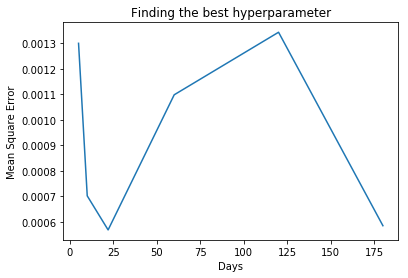

In [29]:
lists = sorted(seq_len_result.items())
x,y = zip(*lists)
plt.plot(x,y)
plt.title('Finding the best hyperparameter')
plt.xlabel('Days')
plt.ylabel('Mean Square Error')
plt.show()